<a href="https://colab.research.google.com/github/WyattRoss/csci4170/blob/main/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Advanced Objective Function and Use Case
## Objective Function derivation

(Binary) Logistic regression defined as:
$\hat y = \text{P}(y=1 | \boldsymbol{\text{x}} ; \text{w}) = σ(\boldsymbol{\text{w}}^T\text{x} + b)$
where and

$σ(a) = (1+e^{-a})^{-1}$ and $a= \boldsymbol{\text{w}}^T + b = log(\frac{p}{1-p})$ where $p = p(y=1 | x ; \text{w})$

So likelihood is $L(\text{w})= ∏^n_{i=1} P(y_i | \boldsymbol{\text{x}} ; \text{w}) = ∏^n_{i=1} (σ(a_i)^{y_i} × (1-σ(a_i))^{1-y_i})$ where $a_i= \boldsymbol{\text{w}}^Tx_i + b$

Thus, the log likelihood is $\text{log}(L(\text{w}))=∑^{n}_{i=1} \text{log}(P(y_i | \text{x} ; \text{w})) = ∑^{n}_{i=1} \text{log}(σ(a_i)^{y_i} × (1-σ(a_i))^{1-y_i})$

Simplifying, $\text{log}(L(\text{w}))=∑^{n}_{i=1} \text{log}(P(y_i | \text{x} ; \text{w})) = ∑^{n}_{i=1} y_i \text{log}(σ(a_i)) + (1-y_i)\text{log}(1-σ(a_i))$

So the negative log likelihood (and thus the objective function) is $\text{NLL}(\text{w})= -∑^{n}_{i=1} \text{log}(P(y_i | \text{x} ; \text{w})) = -∑^{n}_{i=1} y_i \text{log}(σ(a_i)) + (1-y_i)\text{log}(1-σ(a_i))$

MAP estimation is a way of reducing overfitting of MLE based regression techniques by putting a penalty on excessively large weights.

## Definition of a new problem
I'm setting out to take [this dataset](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&qualities.NumberOfFeatures=between_10_100&id=24)<sup>1</sup> which enumerates descriptions of mushrooms and I'm going to attempt to, using logistic regression, estimate whether or not they are poisonous.

This is a simple binary classification problem with categorical independent variables. This is exactly the type of problem logistic regression is well suited to when compared to, say, the perceptron. The perceptron is a fine linear model but it requires that our data is linearly separable, which I haven't verified for this dataset.

## Discussion
This problem has a straightforward mapping to the theory of logistic regression. The vector **y** is the set of "edibility" fields in the data, and the input matrix **x** is all of the other fields.

#### Notes
1: The data, as formatted from the source, uses "class" to denote whether or not a given mushroom is poisonous. This caused a syntax error when referencing it becuase `k.class` is reserved in python. I replaced that attribute name with "edibility". This is the only change I made to the dataset.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.io import arff
from sklearn.linear_model import LinearRegression
import seaborn as sns
from collections import defaultdict

In [ ]:
data = arff.loadarff('mushrooms.arff')
df = pd.DataFrame(data[0])

# drop columns with only 1 variant. They're redundant
for col in df.columns:
  if len(df[col].unique()) == 1:
    df.drop(col, axis=1, inplace=True)

In [ ]:
df.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,edibility
0,b'x',b's',b'n',b't',b'p',b'f',b'c',b'n',b'k',b'e',...,b's',b'w',b'w',b'w',b'o',b'p',b'k',b's',b'u',b'p'
1,b'x',b's',b'y',b't',b'a',b'f',b'c',b'b',b'k',b'e',...,b's',b'w',b'w',b'w',b'o',b'p',b'n',b'n',b'g',b'e'
2,b'b',b's',b'w',b't',b'l',b'f',b'c',b'b',b'n',b'e',...,b's',b'w',b'w',b'w',b'o',b'p',b'n',b'n',b'm',b'e'
3,b'x',b'y',b'w',b't',b'p',b'f',b'c',b'n',b'n',b'e',...,b's',b'w',b'w',b'w',b'o',b'p',b'k',b's',b'u',b'p'
4,b'x',b's',b'g',b'f',b'n',b'f',b'w',b'b',b'k',b't',...,b's',b'w',b'w',b'w',b'o',b'e',b'n',b'a',b'g',b'e'


In [ ]:
df.shape

(8124, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises%3F                8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [ ]:
df.describe()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,edibility
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,4,3,5,9,6,7,2
top,b'x',b'y',b'n',b'f',b'n',b'f',b'c',b'b',b'b',b't',...,b's',b'w',b'w',b'w',b'o',b'p',b'w',b'v',b'd',b'e'
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4936,4464,4384,7924,7488,3968,2388,4040,3148,4208


In [ ]:
df.edibility.value_counts(normalize=True)

,proportion
edibility,
b'e',0.517971
b'p',0.482029


# Task 2: EDA

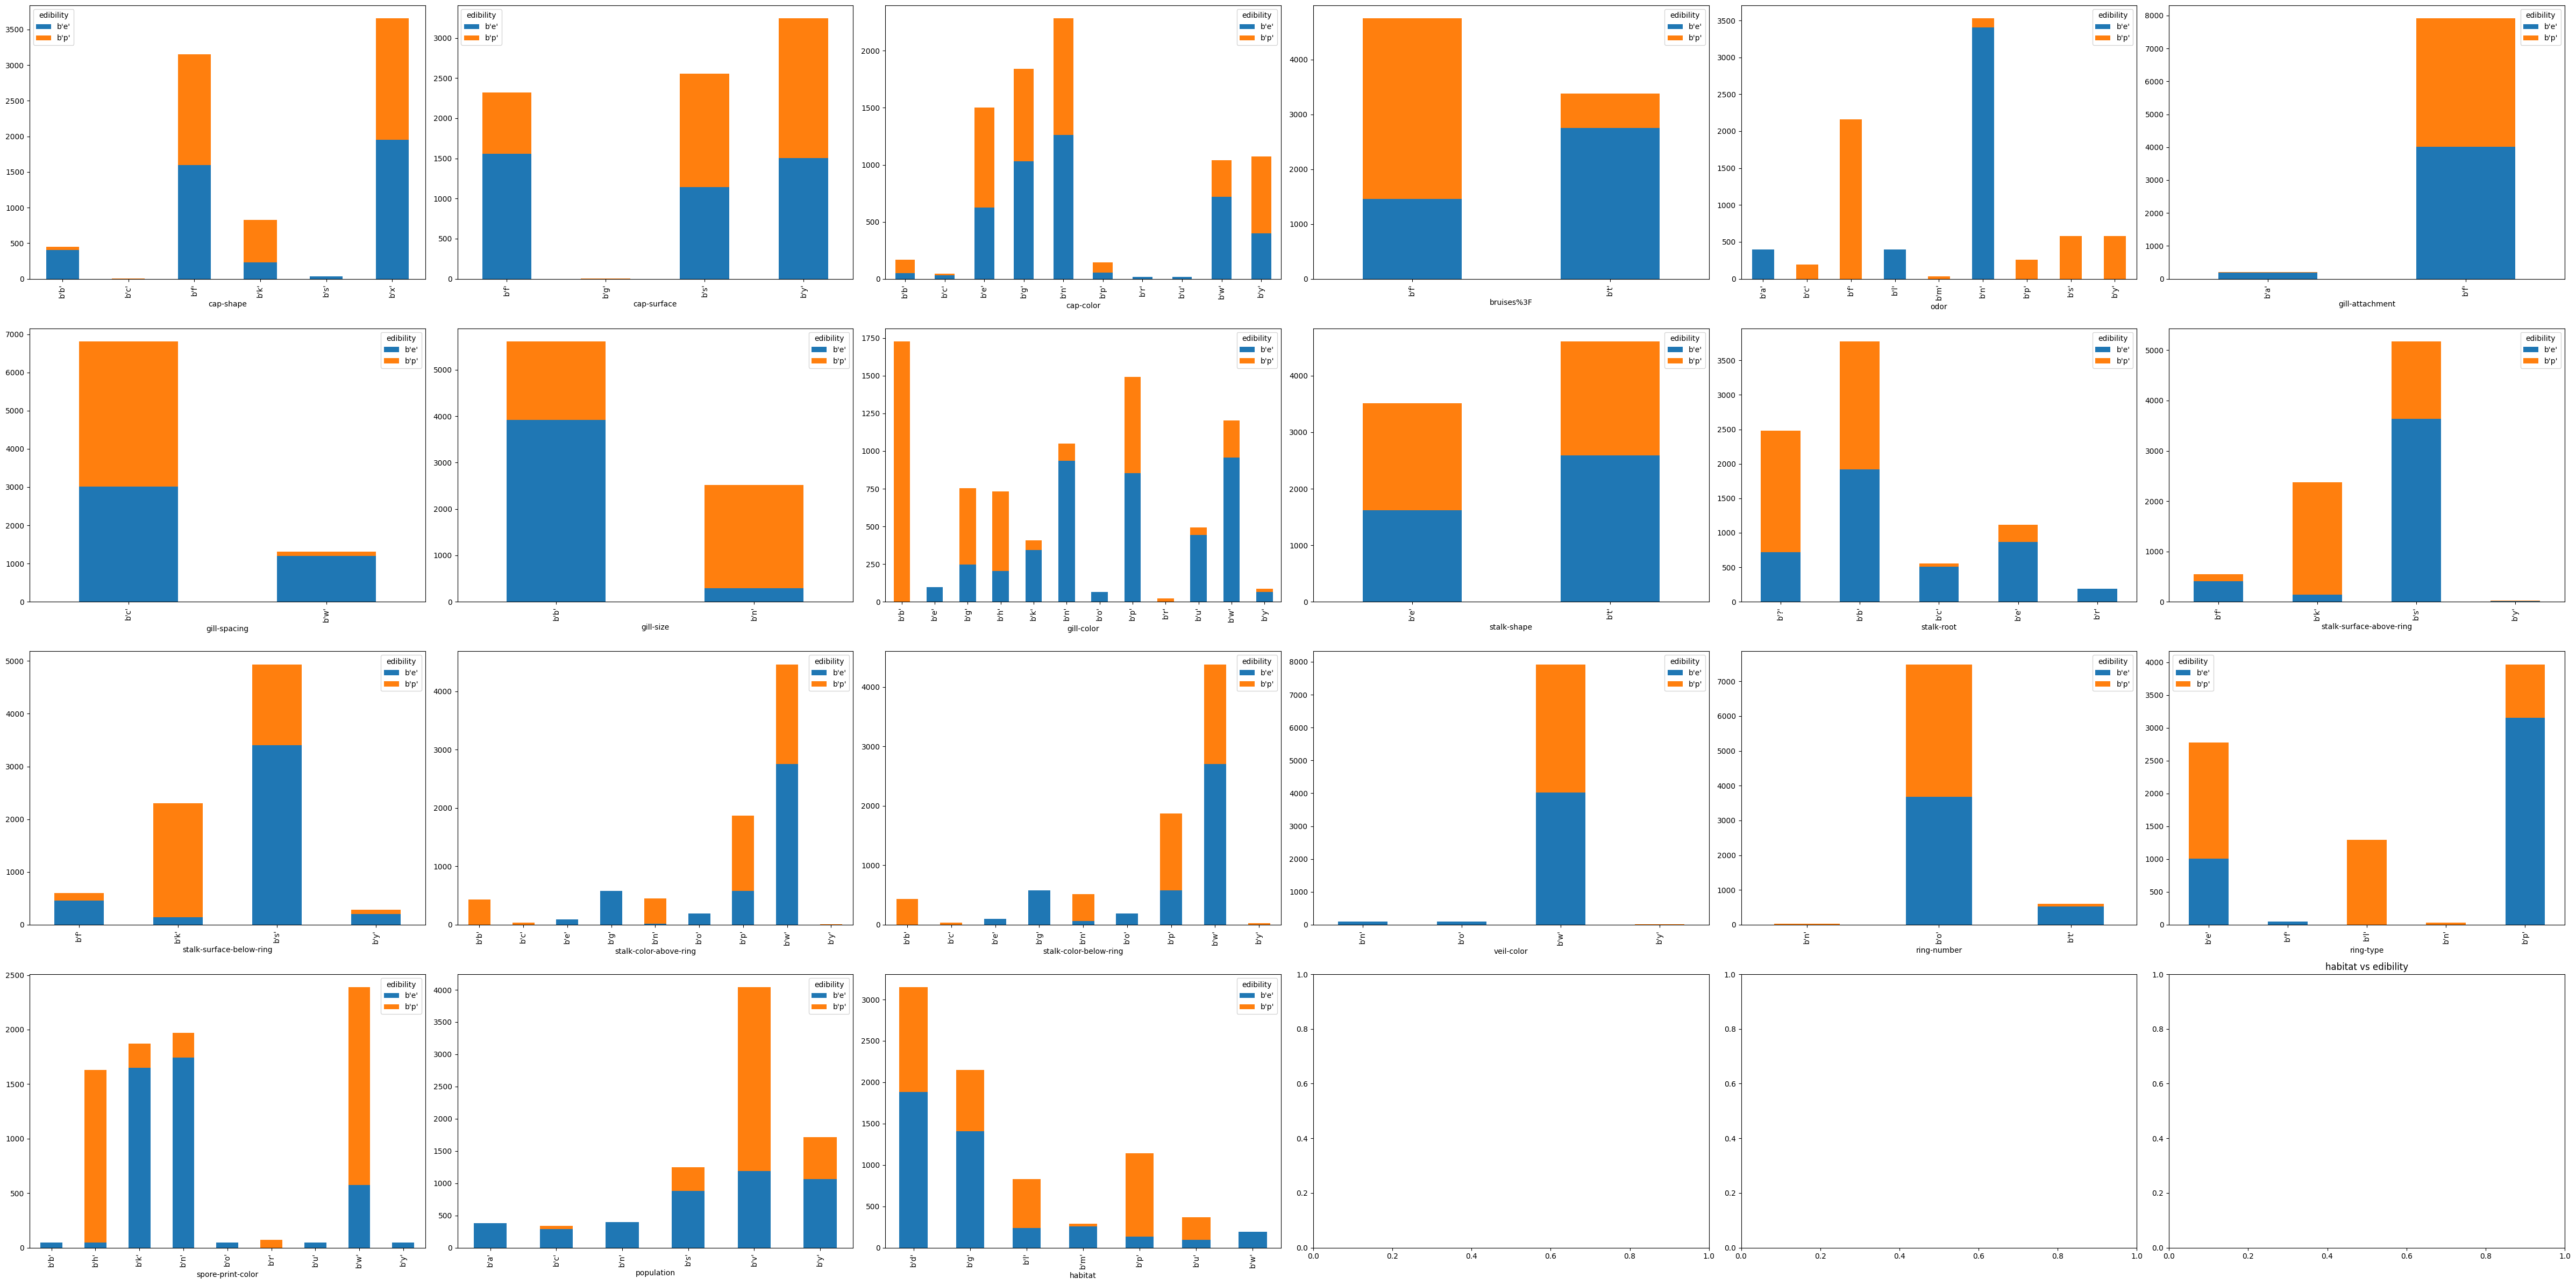

In [ ]:
features = [col for col in df.columns if col != 'edibility']

total = df.groupby('edibility').count().reset_index()

edible = df[df.edibility == b'e']
poisonous = df[df.edibility == b'p']

fig, axes = plt.subplots(4, 6, figsize=(48, 24))
axes = axes.flatten()

total.shape
for i, feature in enumerate(features):
  crosstab = pd.crosstab(df[feature], df.edibility)
  crosstab.plot(kind='bar', stacked=True, ax=axes[i])
  plt.title(f'{feature} vs edibility')

plt.tight_layout()
plt.show()


# Multicolinearity Analysis
VIF requires numerical values, I have nominal categorical values, so I need to remap them.

Mapping feature [a, b, c] to feature [1, 2, 3] is probably information destroying because a, b and c are nominal and not ordinal.

`pandas.get_dummies()` can, and will help by taking feature [a, b, c] and mapping it to three columns [a: True/False], [b: True/False], [c: True/False].

This leads to the problem of having multicolinearity among dummy columns when it doesn't necessarily exist in the features themselves (especially plausible for infrequent categories). Hence, the solution of grouping all categories for a given feature that appear less than some arbitrary frequency to an "other" category, in this case 'q' to avoid collisions.

In [ ]:
def epsilon_filter(input, eps):
  input = df.copy()
  for col in input.columns:
    frequency = df[col].value_counts(normalize=True)
    others = frequency[frequency < eps].index
    input[col] = np.where(input[col].isin(others), b'q', df[col])

  dummies = pd.get_dummies(input[features], drop_first=True)
  return dummies

def compute_vif(input):
  X = input.copy()
  result = []

  for column in X.columns:
    FOI = X[column] #feature-of-interest
    others = X.drop(column, axis=1)

    model = LinearRegression()
    model.fit(others, FOI)

    R2 = model.score(others, FOI)
    if R2 == 1:
      result.append([column, np.inf])
    else:
      result.append([column, 1/(1-R2)])

  return pd.DataFrame(result, columns=['feature', 'VIF'])

def weighted_vif_combine(input, columns):
  frequencies = input.sum() / len(input)
  final_VIF = defaultdict(float)
  for column in columns:
    corresponding_dummies = [col for col in input.columns if col.startswith(column)]
    weights = frequencies[corresponding_dummies]
    VIFs = VIF.set_index('feature').loc[corresponding_dummies, 'VIF']
    final_VIF[column] = (VIFs * weights).sum()/weights.sum()
  return final_VIF

df_copy = df.copy()
edibility = df_copy.edibility.map({b'e': 0, b'p': 1}).to_numpy()
df_copy.drop("edibility", axis=1, inplace=True) # dropping the label
eps = 0.1

dummies = epsilon_filter(df_copy, eps)

VIF = compute_vif(dummies)

Computing a weighted average of the VIF values we calculated for each dummy category to get the VIF of the entire feature

In [ ]:
vif_thresholding = lambda x, t: [col for col in x.index.values if x["VIF"][col] > t]
vif_threshould_count = lambda x, t: len(vif_thresholding(x, t))

# Drop features with a VIF above a given threshold (redundant), and recalculate VIF
def drop_cycle(input_vif, input_df, threshold):
  dropped_df = input_df.copy()
  dropped_features = vif_thresholding(input_vif, threshold)
  for col in dropped_features:
    dropped_df.drop(col, axis=1, inplace=True)
  dummy_df = epsilon_filter(dropped_df, eps)
  dropped_VIF = compute_vif(dummy_df)
  dropped_combined_VIF = weighted_vif_combine(dummy_df, dropped_df.columns)
  dropped_weighted_VIF = pd.DataFrame.from_dict(dropped_combined_VIF, orient='index', columns=['VIF'])
  return (dropped_weighted_VIF, dropped_df, dummy_df)

combined_VIF = weighted_vif_combine(dummies, df_copy.columns)
weighted_VIF = pd.DataFrame.from_dict(combined_VIF, orient='index', columns=['VIF'])

vif_target = 20
VIF_threshold = max(weighted_VIF["VIF"][:]*0.8)

#iteratively drop the features with the highest VIF until all VIFs fall below the target
dropped_weighted_VIF = weighted_VIF.copy()
dropped_df = df_copy.copy()
dummy_df = None
while max(dropped_weighted_VIF["VIF"][:]) > vif_target:
  dropped_weighted_VIF, dropped_df, dummy_df = drop_cycle(dropped_weighted_VIF, dropped_df, VIF_threshold)
  VIF_threshold = max(dropped_weighted_VIF["VIF"][:])*0.8

After first calculating the VIF values for the data, we find that there are many features for which VIF is unnaceptably high, suggesting that those features are well predicted by other features (multicolinearity).

The approach I chose to deal with this multicolinearity was iteratively dropping the features with the highest VIF before recalculating the VIF for that new subset of the data.

This has the advantage of being very simple, but it could (in theory) lose some signal. We'll see how the regression turns out.

In [ ]:
dropped_df.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,population,habitat
0,b'x',b's',b'n',b't',b'p',b'f',b'c',b's',b's',b'w',b'w',b'w',b's',b'u'
1,b'x',b's',b'y',b't',b'a',b'f',b'c',b's',b's',b'w',b'w',b'w',b'n',b'g'
2,b'b',b's',b'w',b't',b'l',b'f',b'c',b's',b's',b'w',b'w',b'w',b'n',b'm'
3,b'x',b'y',b'w',b't',b'p',b'f',b'c',b's',b's',b'w',b'w',b'w',b's',b'u'
4,b'x',b's',b'g',b'f',b'n',b'f',b'w',b's',b's',b'w',b'w',b'w',b'a',b'g'


# Task 3: Implementing Logistic Regression
## Bones

In [ ]:
sigmoid = lambda z: 1 / (1 + np.exp(-z))
predict = lambda x, w, t=0.5: sigmoid(x @ w) > t
accuracy = lambda a, b: np.mean(a == b)
DEFAULT_ITERATIONS = 32

def cost(x, y, w, eps=1e-15): #straightforward Negative-Log-Likelihood
  z = x @ w
  h = sigmoid(z)
  cost = np.sum(y * np.log(h+eps) + (1 - y) * np.log(1-h+eps))
  return cost

def compute_gradient(X, y, w): #again, simple
  h = sigmoid(X @ w)
  gradient = X.T @ (h - y)
  return gradient

## Gradient Descent

In [ ]:
def stochastic_gradient_descent(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS):
  w = np.zeros(x.shape[1])
  m = len(y)

  for i in range(iterations):
    for j in range(m):
      xi = x[j, :].reshape(1, -1)
      yi = y[j]
      gradient = compute_gradient(xi, yi, w)
      w -= alpha * gradient
  return w

def batch_gradient_descent(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS):
  w = np.zeros(x.shape[1])
  cost_history = []
  m = len(y)

  for i in range(iterations):
    grad = compute_gradient(x, y, w)
    w -= alpha * grad
    current_cost = cost(x, y, w)
    cost_history.append(current_cost)
  return w

def mini_batch_gradient_descent(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS, batch_size=32):
  w = np.zeros(x.shape[1])
  m = len(y)

  for i in range(iterations):
    for batch in range(0, m, batch_size):
      x_batch = x[batch:batch+batch_size, :]
      y_batch = y[batch:batch+batch_size]
      grad = compute_gradient(x_batch, y_batch, w)
      w -= alpha * grad
  return w

In [ ]:
data = dummy_df.copy()
data = data.to_numpy()
data = np.hstack([np.ones((data.shape[0], 1)), data])
training_data = data[::2]
testing_data = data[1::2]
training_edibility = edibility[::2]
testing_edibility = edibility[1::2]

In [ ]:
np.random.seed(42)
k_random = np.random.rand(data.shape[1])

In [ ]:
k_sgd = stochastic_gradient_descent(training_data, training_edibility)
print(cost(training_data, training_edibility, k_sgd))

-552.2138433390547


In [ ]:
k_bgd = batch_gradient_descent(training_data, training_edibility)
print(cost(training_data, training_edibility, k_bgd))

-1687.85865174039


<ipython-input-376-e7d520d54ba8>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


In [ ]:
k_mbgd = mini_batch_gradient_descent(training_data, training_edibility)
print(cost(training_data, training_edibility, k_mbgd))

-392.3091765292202


## Convergence behavior
All the gradient descent variants I've implemented minimize the absolute value of the cost function as they converge, but they get there differently. To understand how we should look at the update strategy each variant uses. More specifically, how much data the optimizer looks at to make an update.

Stochastic gradient descent updates one sample at a time, Batch gradient descent evaluates all the available data, and Mini Batch Gradient Descent splits the difference, evaluating some subset of the data each time it updates.

This difference in update frequency (in terms of number of samples evaluated) makes the smaller-sample variants converge more quickly, but perhaps less precisely as the number of epochs increases.

That theory aligns with what we see in practice, over a small number of epochs (32), the loss is worst on the batch descent and best on the stochastic descent. Accuracy is in the .9x range for all variants though, this reveals the difference confidence (or lack thereof) and accuracy.

# Task 4: Optimization & Evaluation

In [ ]:
def momentum(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS, batch_size=32, gamma = 0.9):
  w = np.zeros(x.shape[1])
  m = len(y)
  v = np.zeros(x.shape[1])

  for i in range(iterations):
    grad = compute_gradient(x, y, w)
    v = v * gamma + alpha * grad
    w -= v

  return w

def rmsprop(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS, batch_size=32, beta = 0.9, epsilon = 1e-15):
  w = np.zeros(x.shape[1])
  m = len(y)
  s = np.zeros(x.shape[1])

  for i in range(iterations):
    grad = compute_gradient(x, y, w)
    s = beta * s + (1 - beta) * grad**2
    w -= alpha/(epsilon + (s ** 0.5)) * grad

  return w

def adam(x, y, alpha=0.1, iterations=DEFAULT_ITERATIONS, batch_size=32, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-15):
  w = np.zeros(x.shape[1])
  m = len(y)
  v = np.zeros(x.shape[1])
  s = np.zeros(x.shape[1])

  for i in range(iterations):
    grad = compute_gradient(x, y, w)
    v = beta1 * v + (1 - beta1) * grad
    s = beta2 * s + (1 - beta2) * grad**2

    v_corrected = v / (1 - beta1 ** (i + 1))
    s_corrected = s / (1 - beta2 ** (i + 1))

    w -= alpha/(epsilon + (s_corrected ** 0.5)) * v_corrected

  return w




In [ ]:
k_momentum = momentum(training_data, training_edibility)
print(cost(training_data, training_edibility, k_momentum))

-1775.2986737589797


<ipython-input-376-e7d520d54ba8>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


In [ ]:
k_rmsprop = rmsprop(training_data, training_edibility)
print(cost(training_data, training_edibility, k_rmsprop))

-311.13656042279064


In [ ]:
k_adam = adam(training_data, training_edibility)
print(cost(training_data, training_edibility, k_adam))

-300.0189962918064


In [ ]:
print(f"Accuracy on the training data using Random Weights: {accuracy(predict(training_data, k_random), training_edibility)}")
print(f"Accuracy on the withheld data using Random Weights: {accuracy(predict(testing_data, k_random), testing_edibility)}")
print()

print(f"Accuracy on the training data using SGD: {accuracy(predict(training_data, k_sgd), training_edibility)}")
print(f"Accuracy on the withheld data using SGD: {accuracy(predict(testing_data, k_sgd), testing_edibility)}")
print()

print(f"Accuracy on the training data using BGD: {accuracy(predict(training_data, k_bgd), training_edibility)}")
print(f"Accuracy on the withheld data using BGD: {accuracy(predict(testing_data, k_bgd), testing_edibility)}")
print()

print(f"Accuracy on the training data using MBGD: {accuracy(predict(training_data, k_mbgd), training_edibility)}")
print(f"Accuracy on the withheld data using MBGD: {accuracy(predict(testing_data, k_mbgd), testing_edibility)}")

print(f"Accuracy on the training data using Momentum: {accuracy(predict(training_data, k_momentum), training_edibility)}")
print(f"Accuracy on the withheld data using Momentum: {accuracy(predict(testing_data, k_momentum), testing_edibility)}")
print()

print(f"Accuracy on the training data using Momentum: {accuracy(predict(training_data, k_momentum), training_edibility)}")
print(f"Accuracy on the withheld data using Momentum: {accuracy(predict(testing_data, k_momentum), testing_edibility)}")
print()

print(f"Accuracy on the training data using RMSProp: {accuracy(predict(training_data, k_rmsprop), training_edibility)}")
print(f"Accuracy on the withheld data using RMSProp: {accuracy(predict(testing_data, k_rmsprop), testing_edibility)}")
print()

print(f"Accuracy on the training data using Adam: {accuracy(predict(training_data, k_adam), training_edibility)}")
print(f"Accuracy on the withheld data using Adam: {accuracy(predict(testing_data, k_adam), testing_edibility)}")

Accuracy on the training data using Random Weights: 0.47685869030034467
Accuracy on the withheld data using Random Weights: 0.48719842442146727

Accuracy on the training data using SGD: 0.9212210733628754
Accuracy on the withheld data using SGD: 0.9281142294436239

Accuracy on the training data using BGD: 0.9702117183653373
Accuracy on the withheld data using BGD: 0.9679960610536681

Accuracy on the training data using MBGD: 0.9684884293451502
Accuracy on the withheld data using MBGD: 0.9707040866568193
Accuracy on the training data using Momentum: 0.9586410635155096
Accuracy on the withheld data using Momentum: 0.9537173806006893

Accuracy on the training data using Momentum: 0.9586410635155096
Accuracy on the withheld data using Momentum: 0.9537173806006893

Accuracy on the training data using RMSProp: 0.9672575086164451
Accuracy on the withheld data using RMSProp: 0.964303298867553

Accuracy on the training data using Adam: 0.9638109305760709
Accuracy on the withheld data using Adam

<ipython-input-319-6f41aa271d0d>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


# Evaluation


In [ ]:
true_values = testing_edibility
def compute_confustion_matrix(y_pred, y_true=true_values):
  true_positives = np.sum((y_true == 1) & (y_pred == 1))
  true_negatives = np.sum((y_true == 0) & (y_pred == 0))
  false_positives = np.sum((y_true == 0) & (y_pred == 1))
  false_negatives = np.sum((y_true == 1) & (y_pred == 0))

  return np.array([
      [true_positives, false_positives],
      [false_negatives, true_negatives]
  ])

def plot(matrix, name, axis=0):
  group_names = ["True Positive", "False Positive", "False Negative", "True Negative"]
  group_counts = [f"{value:,.0f}" for value in matrix.flatten()]
  annotations = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
  annot_matrix = np.array(annotations).reshape(2, 2)

  confusion_df = pd.DataFrame(matrix)
  sns.heatmap(confusion_df, annot=annot_matrix, fmt="", cmap='Blues', ax=axis, cbar=False)
  axis.set_title(f"{name} Confusion Matrix")
  axis.set_xlabel("")
  axis.set_ylabel("")

In [ ]:
adam_predictions = predict(testing_data, k_adam)
momentum_predictions = predict(testing_data, k_momentum)
rmsprop_predictions = predict(testing_data, k_rmsprop)
stochastic_predictions = predict(testing_data, k_sgd)
batch_predictions = predict(testing_data, k_bgd)
mini_batch_predictions = predict(testing_data, k_mbgd)

adam_confusion = compute_confustion_matrix(adam_predictions)
momentum_confusion = compute_confustion_matrix(momentum_predictions)
rmsprop_confusion = compute_confustion_matrix(rmsprop_predictions)
stochastic_confusion = compute_confustion_matrix(stochastic_predictions)
batch_confusion = compute_confustion_matrix(batch_predictions)
mini_batch_confusion = compute_confustion_matrix(mini_batch_predictions)

all_confusion_matrices = [adam_confusion, momentum_confusion, rmsprop_confusion, stochastic_confusion, batch_confusion, mini_batch_confusion]
all_names = ["Adam", "Momentum", "RMSProp", "Stochastic", "Batch", "Mini-Batch"]

<ipython-input-319-6f41aa271d0d>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


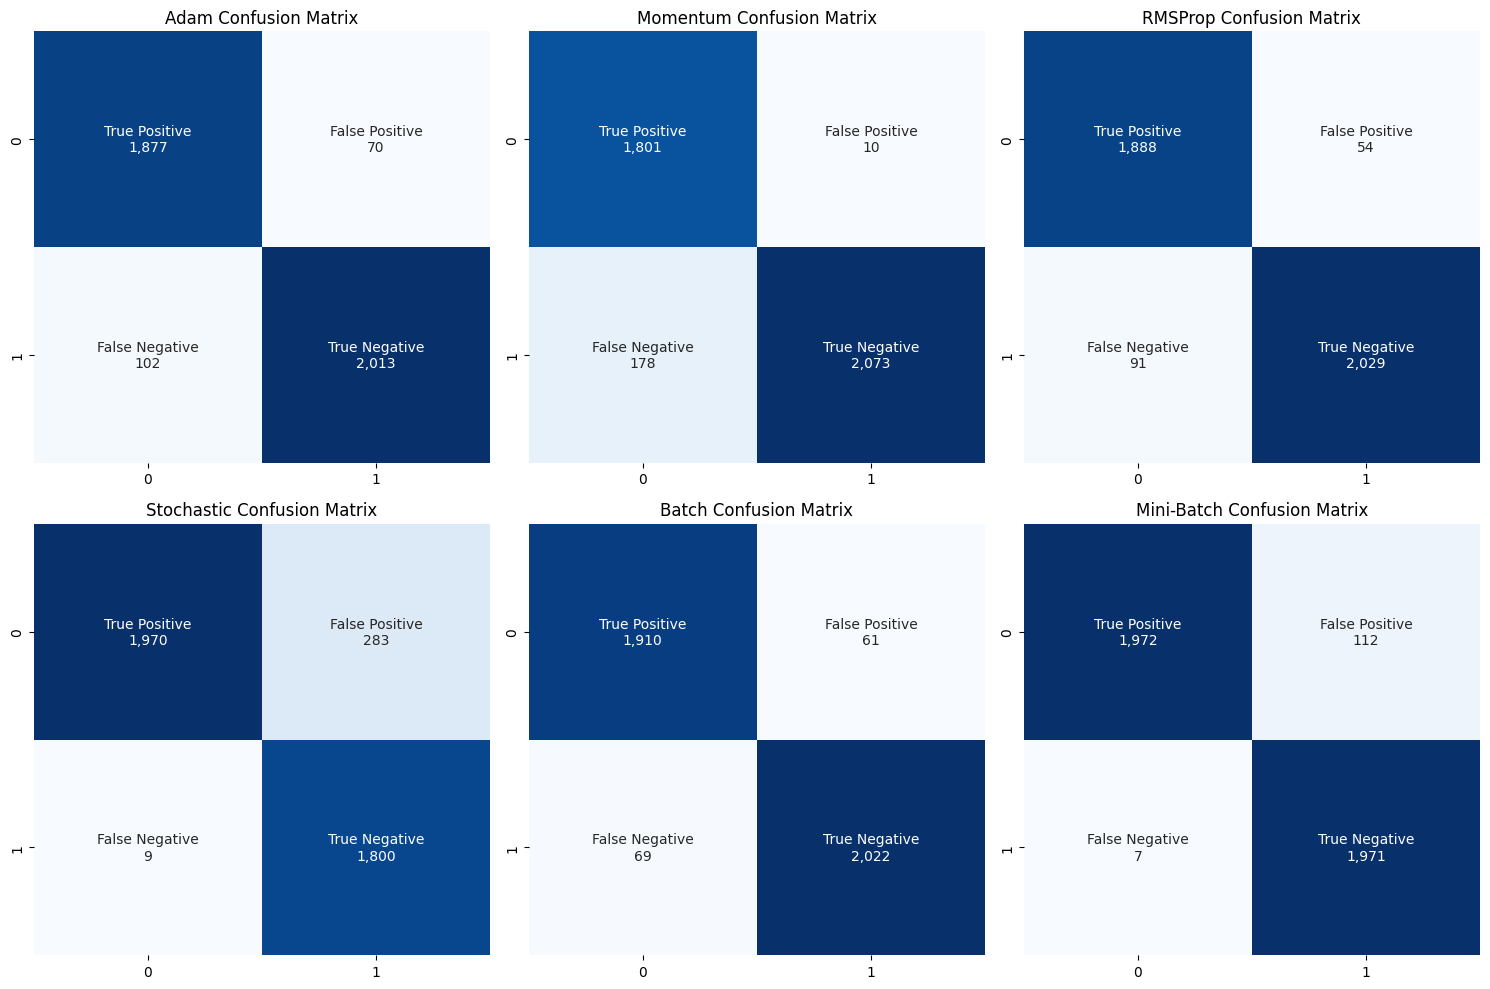

In [ ]:
_, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
  plot(all_confusion_matrices[i], all_names[i], axis=axes[i])
plt.tight_layout()
plt.show()

As far as evaluation goes, there are several approaches. All rely on the confusion matrices produced above, they take the form of
$
\begin{bmatrix}
\text{True Positive (TP)} & \text{False Positive (FP)} \\
\text{False Negative (FN)} & \text{True Negative (TN)} \\
\end{bmatrix}
$

For our purposes a false positive is predicting an edible mushroom to be poisonous. The most damaging incorrect prediction is therefore the false negative - the predicting of a poisonous mushroom as edible.

For that reason, I define the miss-rate as the False Negative Rate $FNR = \frac{FN}{TP+FN}$. It just so happens that this is the inverse of the recall metric (the True Positive Rate) $TPR = \frac{TP}{TP+FN}$. This is because recall and False Negative Rate sum to 1 by definition.

Another useful metric for this particular model is specificity or the True Negative Rate $TNR=\frac{TN}{TN+FP}$. TNR tells us how often the model will correctly identify an edible mushroom. This is not as important as avoiding poisonous mushrooms, but it's still important.

These metrics, however, are evaluating disjoint sets. So a harmonic mean, like the one used in the F1 metric, doesn't have a great real-world interpretation. Instead I've decided to use custom score metric defined as $\text{score}=0.8*\text{recall}+0.2*\text{specificity}$. The weights are ultimately arbitrary, but they reflect my preference towards not accidentally eating poisonous mushrooms!

Perhaps there's some simulation or learning application which could optimize those weights based on required nutrition to survive and the risk of dying from a bad mushroom. Such a problem is beyond the scope of this project however.

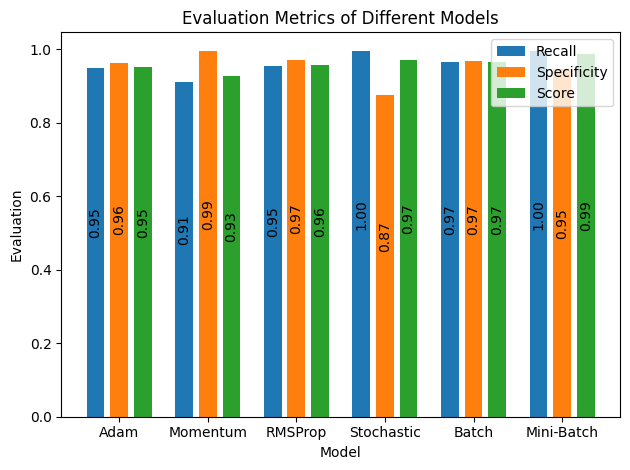

In [ ]:
FNR = lambda matrix: matrix[1, 0] / (matrix[0, 0] + matrix[1, 0])
recall = lambda matrix: 1 - FNR(matrix)
specificity = lambda matrix: matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])
score = lambda matrix: 0.8*recall(matrix) + 0.2*specificity(matrix)
generate_triple = lambda matrix: np.array([recall(matrix), specificity(matrix), score(matrix)])

all_triples = np.array([generate_triple(matrix) for matrix in all_confusion_matrices])

metric_names = ["Recall", "Specificity", "Score"]
metrics = all_triples.shape[1]
models = all_triples.shape[0]
x_axis_labels = np.arange(models) * 1.5
width = 0.3

fig, axis = plt.subplots()

axis.set_xticks(x_axis_labels)
axis.set_xticklabels(all_names)

axis.set_ylabel("Evaluation")
axis.set_xlabel("Model")
axis.set_title("Evaluation Metrics of Different Models")

bars = []
for i in range(metrics):
  offset = (i - 1) * (width+.1)
  b = axis.bar(x_axis_labels + offset, all_triples[:, i], width, label=metric_names[i])
  bars.append(b)
axis.legend()

for group in bars:
  for bar in group:
      height = bar.get_height()
      axis.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height/2), xytext=(0, 3),
                  textcoords="offset points", ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning
Hyperparameters are things like the learning rate, the number of iterations, or the regularization strength (I'm not regularizing).

I'm going to do grid search with both the learning rate and the number of iterations. I'm using the following values:
- α = [.001, .01, .1]
- iterations = [32, 64, 128, 256]

My choices for learning rate are ultimately arbitrary. Just 3 orders of magnitude.

My choices for iteration count were informed by both computation time and by some extreme diminishing returns I observed when testing earlier with high iteration counts.

To discriminate between the different sets of hyperparameters I'm using my score function as defined above. It values the things I value with regard to this problem.

In [ ]:
alphas = [.01, .1, 1]
iter_counts = [32, 64, 128, 256]

best_params = {}
for name in all_names:
  best_params[name] = ((), -1) #arbitrarily low

methods = [adam, momentum, rmsprop, stochastic_gradient_descent, batch_gradient_descent, mini_batch_gradient_descent]

for method in range(len(methods)):
  for alpha in alphas:
    for count in iter_counts:
        trained_weights = methods[method](training_data, training_edibility, alpha=alpha, iterations=count)
        predictions = predict(testing_data, trained_weights)
        confusion = compute_confustion_matrix(predictions)
        score_value = score(confusion)

        if score_value > best_params[all_names[method]][1]:
          best_params[all_names[method]] = ((alpha, count), score_value)

<ipython-input-376-e7d520d54ba8>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


In [ ]:
print("Optimal Hyperparameters:")
for name, ((alpha, iterations), eval) in best_params.items():
  print(f"\t{name}: alpha = {alpha}, iterations = {iterations} | score = {eval:.5}")

Optimal Hyperparameters:
	Adam: alpha = 0.1, iterations = 256 | score = 0.99717
	Momentum: alpha = 0.01, iterations = 256 | score = 0.99656
	RMSProp: alpha = 0.1, iterations = 256 | score = 0.99717
	Stochastic: alpha = 0.1, iterations = 256 | score = 0.99879
	Batch: alpha = 0.01, iterations = 256 | score = 0.99616
	Mini-Batch: alpha = 0.1, iterations = 256 | score = 0.99879


## Practical Decisions
The most obvious tradeoff between the various optimizers implemented above is computational complexity (time complexity). Full-sample batch methods are the fastest, but may take more iterations to reach the same evaluation as slower, more piecewise approaches like Stochastic Descent.

So in general, I think smaller datasets lend themselves towards methods like mini-batch descent and stochastic descent while larger datasets lend themselves towards the others.

I implemented the optimizers for this task (task 4) in the paradigm of Batch Gradient Descent because it was easy and fast, but there's no reason you couldn't put such an update rule in another method like stochastic descent. In particular, a momentum based approach (as implemented below) might smooth out some of the noise typical of Stochastic Gradient Descent.

In [ ]:
def stochastic_gradient_descent_momentum(x, y, alpha=0.1, gamma=0.9, iterations=DEFAULT_ITERATIONS):
  w = np.zeros(x.shape[1])
  m = len(y)
  v = np.zeros(x.shape[1])

  for i in range(iterations):
    for j in range(m):
      xi = x[j, :].reshape(1, -1)
      yi = y[j]
      gradient = compute_gradient(xi, yi, w)
      v = v * gamma + alpha * gradient
      w -= v
  return w

In [ ]:
k_sgdm = stochastic_gradient_descent_momentum(training_data, training_edibility)
print(cost(training_data, training_edibility, k_sgdm))

-1550.0993967545082


In [ ]:
print(f"Accuracy on the training data using SGD with momentum: {accuracy(predict(training_data, k_sgdm), training_edibility)}")
print(f"Accuracy on the withheld data using SGD with momentum: {accuracy(predict(testing_data, k_sgdm), testing_edibility)}")
print()

Accuracy on the training data using SGD with momentum: 0.9576563269325455
Accuracy on the withheld data using SGD with momentum: 0.9650418513047759



Loss is worse than normal Stochastic Descent, but baseline accuracy is better. The first part is unsurprising, but improved accuracy over a small number of epochs is *very* surprising to me. Maybe it's something to do with the initial conditions?

Recall: 1.0
Specificity: 0.93305
Score: 0.98661


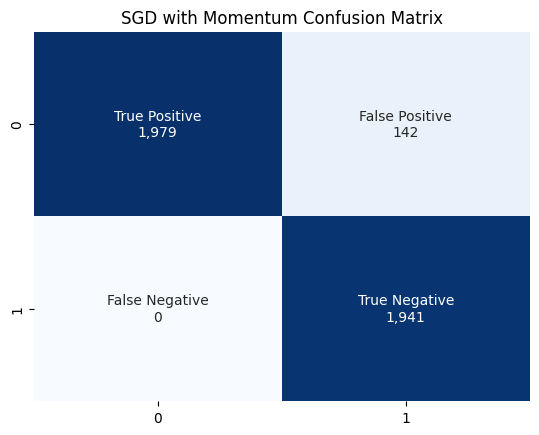

In [ ]:
sgdm_confusion = compute_confustion_matrix(predict(testing_data, k_sgdm), testing_edibility)
sgdm_recall, sgdm_specificity, sgdm_score = generate_triple(sgdm_confusion)
print(f"Recall: {sgdm_recall:.5}")
print(f"Specificity: {sgdm_specificity:.5}")
print(f"Score: {sgdm_score:.5}")
plot(sgdm_confusion, "SGD with Momentum", axis=plt.gca())

Momentum based stochastic descent also improves on normal stochastic descent when evaluated by the three evaluation metrics from earlier. Admittedly, I didn't make a prediction before calculating the scores so I can't really say whether or not I was surprised, unfortunately.

In [ ]:
best_score = -1
best_params_sgdm = None
for alpha in alphas:
  for count in iter_counts:
    trained_weights = stochastic_gradient_descent_momentum(training_data, training_edibility, alpha=alpha, iterations=count)
    predictions = predict(testing_data, trained_weights)
    confusion = compute_confustion_matrix(predictions)
    score_value = score(confusion)

    if score_value > best_score:
      best_score = score_value
      best_params_sgdm = (alpha, count)

print(f"Optimal Hyperparameters: alpha = {best_params_sgdm[0]}, iterations = {best_params_sgdm[1]}")
print(f"Score: {best_score:.5}")

<ipython-input-376-e7d520d54ba8>:1: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda z: 1 / (1 + np.exp(-z))


Optimal Hyperparameters: alpha = 0.01, iterations = 256
Score: 0.99879


Optimization of hyperparameters yields an α smaller than that of normal Stochastic Descent. This surprised me! Obviously this has something to do with reduced noise, but I'm really not sure why with any great level of precision.

# Citations
1.